# Beta series regression

1. [To Do](#to-do) <br>
2. [fMRIprep](#fmriprep) <br>
3. [Nibetaseries](#nibetaseries) <br>
4. Age Group Differences <br>
    1. [Mean FC during cue condition](#age-group-dif-mean-fc) <br>

HC node: x=-21, y=-9, z=-15) left anterior hc

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib  # load the beta maps in python
from nilearn import plotting  # plot nifti images
from bct import nbs
from scipy.io import savemat
from mne.viz import plot_connectivity_circle
import time

/usr/local/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
data_dir = '/Volumes/psybrain/ADM/derivatives'
results_dir = '/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/stats/'
nibs_dir='/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries'

tasks = ['MemMatch1', 'MemMatch2', 'MemMatch3']
trial_types = ['cue', 'match', 'mismatch']

atlas_file='/Volumes/psybrain/ADM/derivatives/nibs/power264-master/power264MNI.nii.gz'
atlas_lut='/Volumes/psybrain/ADM/derivatives/nibs/power264_labels.tsv'

In [3]:
subjects = np.loadtxt(data_dir + '/nibs/subjects.txt', dtype=str)

print("YA n=", len(np.flatnonzero(np.char.startswith(subjects, '3'))))
print("OA n=", len(np.flatnonzero(np.char.startswith(subjects, '4'))))

YA n= 51
OA n= 39


In [4]:
atlas = pd.read_csv(atlas_lut, sep='\t').set_index('index')
atlas = atlas.append({'regions': 'L Anterior Hippocampus'}, ignore_index=True)
atlas = atlas.append({'regions': 'R Anterior Hippocampus'}, ignore_index=True)
atlas.regions.unique()

array(['Uncertain', 'Sensory/somatomotor Hand',
       'Sensory/somatomotor Mouth', 'Cingulo-opercular Task Control',
       'Auditory', 'Default mode', 'Memory retrieval?',
       'Ventral attention', 'Visual', 'Fronto-parietal Task Control',
       'Salience', 'Subcortical', 'Cerebellar', 'Dorsal attention',
       'L Anterior Hippocampus', 'R Anterior Hippocampus'], dtype=object)

In [5]:
hc = atlas.loc[atlas['regions'].str.contains('Hippocampus')].index.tolist()

In [6]:
hc_coords = np.vstack([[-21,-9,-15], [21,-9,-15]])

```for subject in subjects:
    for task in tasks:
        confounds_file = data_dir + '/fmriprep/sub-%s/func/sub-%s_task-%s_run-01_desc-confounds_regressors.tsv' % (subject, subject, task)
        print(confounds_file)
        
        confounds = pd.read_csv(confounds_file, sep = '\t')
        for colname in ['bad_tr', 'ones', 'zeros', 'motion_outlier_01']:
            if colname in confounds.columns:
                confounds.drop(colname, axis=1, inplace=True)
        if not os.path.exists(confounds_file.split('.tsv')[0] + '_original.tsv'):
            confounds.to_csv(confounds_file.split('.tsv')[0] + '_original.tsv', index=False, sep = '\t')

        confounds['motion_outlier_00'] = np.where(confounds['framewise_displacement'] >= 0.5, 1, 0)
#         confounds['motion_outlier_01'] = np.ones(len(confounds['framewise_displacement']), dtype=int)
        confounds.to_csv(confounds_file, index=False, sep = '\t')
        
        print(confounds.loc[confounds['motion_outlier_00'] > 0.5])
        
```

In [7]:
events_files = glob.glob('/Volumes/psybrain/ADM/sub-40782/func/*events.tsv')
print(events_files)


['/Volumes/psybrain/ADM/sub-40782/func/sub-40782_task-MemMatch3_run-01_events.tsv', '/Volumes/psybrain/ADM/sub-40782/func/sub-40782_task-MemRepeat3_run-01_events.tsv', '/Volumes/psybrain/ADM/sub-40782/func/sub-40782_task-MemRepeat1_run-01_events.tsv', '/Volumes/psybrain/ADM/sub-40782/func/sub-40782_task-MemMatch2_run-01_events.tsv', '/Volumes/psybrain/ADM/sub-40782/func/sub-40782_task-MemMatch1_run-01_events.tsv', '/Volumes/psybrain/ADM/sub-40782/func/sub-40782_task-MemRepeat2_run-01_events.tsv']


# Nibetaseries <a id='nibetaseries'></a>

```bash

cd /Volumes/psybrain/ADM/derivatives/nibs/
rm -rf nibetaseries_work/.smb*

for subject in `cat remaining.txt | tail -10`; do
    echo $subject
    printf '\n\n RUN 1'
    nibs --nthreads 1 -n-cpus 1 -c a_comp_cor_00 trans_x trans_y trans_z rot_x rot_y rot_z motion_outlier_00 -t MemMatch1 --participant-label $subject --estimator lss --hrf-model 'spm + derivative' -sm 6 /Volumes/psybrain/ADM /Volumes/psybrain/ADM/derivatives/fmriprep /Volumes/psybrain/ADM/derivatives/nibs participant; sleep 10;
    printf '\n\n RUN 2'
    nibs --nthreads 1 -n-cpus 1 -c a_comp_cor_00 trans_x trans_y trans_z rot_x rot_y rot_z motion_outlier_00 -t MemMatch2 --participant-label $subject --estimator lss --hrf-model 'spm + derivative' -sm 6 /Volumes/psybrain/ADM /Volumes/psybrain/ADM/derivatives/fmriprep /Volumes/psybrain/ADM/derivatives/nibs participant; sleep 10;
    printf '\n\n RUN 3'
    nibs --nthreads 1 -n-cpus 1 -c a_comp_cor_00 trans_x trans_y trans_z rot_x rot_y rot_z motion_outlier_00 -t MemMatch3 --participant-label $subject --estimator lss --hrf-model 'spm + derivative' -sm 6 /Volumes/psybrain/ADM /Volumes/psybrain/ADM/derivatives/fmriprep /Volumes/psybrain/ADM/derivatives/nibs participant; sleep 10;
    echo "completed subjects: " 
    echo `ls nibetaseries/. | wc -l`
done




### Concatenate runs 1, 2, and 3 of MemMatch task in 4th dimension for each subject

In [47]:
%%bash

out_dir=/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries

for subject in `cat /Volumes/psybrain/ADM/derivatives/nibs/subjects.txt`; do
    echo $subject
    if [ ! -f ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz ]; then
      fslmerge -t ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch1_run-1_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch2_run-1_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch3_run-1_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
      fslmerge -t ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-match_betaseries.nii.gz ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch1_run-1_space-MNI152NLin2009cAsym_desc-match_betaseries.nii.gz ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch2_run-1_space-MNI152NLin2009cAsym_desc-match_betaseries.nii.gz ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch3_run-1_space-MNI152NLin2009cAsym_desc-match_betaseries.nii.gz
      fslmerge -t ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-mismatch_betaseries.nii.gz ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch1_run-1_space-MNI152NLin2009cAsym_desc-mismatch_betaseries.nii.gz ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch2_run-1_space-MNI152NLin2009cAsym_desc-mismatch_betaseries.nii.gz ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch3_run-1_space-MNI152NLin2009cAsym_desc-mismatch_betaseries.nii.gz
      fi
done


30004
30008
30009
30015
30019
30020
30023
30040
30057
30064
30066
30069
30074
30085
30088
30090
30091
30095
30096
30105
30116
30118
30119
30128
30181
30217
30227
30236
30242
30255
30274
30283
30295
30330
30346
30376
30395
30400
30403
30412
30426
30432
30466
30469
30476
30478
30568
30570
30581
30584
30588
40160
40170
40175
40288
40351
40490
40512
40519
40520
40524
40547
40564
40615
40619
40624
40638
40649
40650
40656
40658
40664
40665
40668
40672
40685
40694
40720
40738
40743
40750
40773
40778
40796
40803
40855
40861
40930
40961
40968


Image Exception : #63 :: No image files match: /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40930/func/sub-40930_task-MemMatch1_run-1_space-MNI152NLin2009cAsym_desc-cue_betaseries
libc++abi.dylib: terminating with uncaught exception of type std::runtime_error: No image files match: /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-40930/func/sub-40930_task-MemMatch1_run-1_space-MNI152NLin2009cAsym_desc-cue_betaseries
bash: line 4: 65371 Abort trap: 6           fslmerge -t ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch1_run-1_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch2_run-1_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz ${out_dir}/sub-${subject}/func/sub-${subject}_task-MemMatch3_run-1_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
Image Exception : #63 

In [48]:
%%bash
out_dir=/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries
ls ${out_dir}/sub-*/func/sub-*_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz | wc -l
ls ${out_dir}/sub-3*/func/sub-3*_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz | wc -l
ls ${out_dir}/sub-4*/func/sub-4*_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz | wc -l

      89
      51
      38


In [8]:
subjects = sorted([os.path.basename(x).split('sub-')[1] for x in glob.glob(nibs_dir + '/sub-*')])
print(subjects[-7:])

['40778', '40796', '40803', '40855', '40861', '40961', '40968']


In [9]:
x0 = np.load('/Volumes/psybrain/ADM/derivatives/nibs/memmatch_fc.npy', allow_pickle=True).flat[0]

30004
/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-30004/func/sub-30004_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-30004/func/sub-30004_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Smoothing images
[NiftiSpheresMasker.transform_single_imgs] Extracting region signals
[NiftiSpheresMasker.transform_single_imgs] Cleaning extracted signals


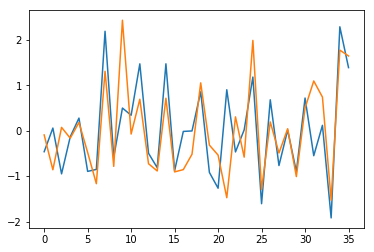

name 'atlas_all' is not defined
30008
/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-30008/func/sub-30008_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Loading data from /Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-30008/func/sub-30008_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_betaseries.nii.gz


In [ ]:
from nilearn.input_data import NiftiLabelsMasker, NiftiSpheresMasker
from nilearn.connectome import ConnectivityMeasure
from sklearn.covariance import EmpiricalCovariance
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from mne.viz import plot_connectivity_circle
import re

i=0
fc_subs=[]
x = {}

def _fisher_r_to_z(x):
    import numpy as np
    # correct any rounding errors
    # correlations cannot be greater than 1.
    x = np.clip(x, -1, 1)

    return np.arctanh(x)

for trial_type in trial_types[:1]:
    
    x[trial_type] = np.zeros((2,2, len(subjects)))
    
    for subject in subjects:
        print(subject)
        nibs_dir = '/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/sub-' + subject + '/func/'
        out_dir= '/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/with_hc2/sub-' + subject + '/func/'

        if not os.path.exists(out_dir.split('/func')[0]):
            os.mkdir(out_dir.split('/func')[0])

        if not os.path.exists(out_dir):
            os.mkdir(out_dir)

        os.chdir(out_dir)

        start_time = time.time()
    
    
        # extract timeseries from every label

#         if not os.path.exists(os.path.join(nibs_dir, 'sub-' + subject + '_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-' + trial_type + '_correlation_withhc.tsv')):
            
        try: 
            timeseries_file= nibs_dir + 'sub-' + subject + '_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-' + trial_type + '_betaseries.nii.gz'
            print(timeseries_file)

            hc_masker = NiftiSpheresMasker(hc_coords, smoothing_fwhm=6, radius=5.,standardize=True,
                                                   verbose=1)

            timeseries = hc_masker.fit_transform(timeseries_file)

            plt.plot(timeseries)
            plt.show()
            plt.close()

            # create correlation matrix
            correlation_measure = ConnectivityMeasure(cov_estimator=EmpiricalCovariance(),
                                                      kind="correlation")
            correlation_matrix = correlation_measure.fit_transform([timeseries])[0]
            np.fill_diagonal(correlation_matrix, np.NaN)

            # add the atlas labels to the matrix
            regions = atlas_all.regions
            correlation_matrix_df = pd.DataFrame(correlation_matrix, index=regions, columns=regions)

            # do a fisher's r -> z transform
            fisher_z_matrix_df = correlation_matrix_df.apply(_fisher_r_to_z)

            # write out the file.

            corr_mat_fname = 'sub-' + subject + '_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-' + trial_type + '_correlation_withhc.tsv'
            corr_mat_path = os.path.join(out_dir, corr_mat_fname)
            fisher_z_matrix_df.to_csv(corr_mat_path, sep='\t', na_rep='n/a')

            # visualizations with mne
            connmat = fisher_z_matrix_df.values
            labels = list(fisher_z_matrix_df.index)

            # plot a circle visualization of the correlation matrix
            viz_mat_fname = 'sub-' + subject + '_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-' + trial_type + '_correlation_withhc.png'
            viz_mat_path = os.path.join(out_dir, viz_mat_fname)

            n_lines = int(np.sum(connmat > 0) / 2)
            fig = plt.figure(figsize=(5, 5))

            plot_connectivity_circle(connmat, labels, n_lines=n_lines, fig=fig, title='correlation %s concat' % trial_type,
                                     fontsize_title=10, facecolor='white', textcolor='black',
                                     colormap='jet', colorbar=1, node_colors=['black'],
                                     node_edgecolor=['white'], show=False, interactive=False)

            fig.savefig(viz_mat_path, dpi=300)
            plt.close()
            
            print('i = %.f' % i)
            x[trial_type][:,:,i] = np.vstack(fisher_z_matrix_df)
            print(x[trial_type].shape)
            np.fill_diagonal(x[trial_type][:,:,i], 0, wrap=False)
            plt.imshow(x[trial_type][:,:,i])
            plt.title(subject)
            plt.show()
            
            fc_subs.append(str(subject))

            end_time = time.time()

            i+=1

            print('execution time: %s' % (end_time - start_time))

        except Exception as e:
            print(e)

np.savetxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc2/fcsubs.txt', fc_subs, fmt='%s')
np.save('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc2/memmatch_fc_withhc.npy', x)
savemat('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc2/memmatch_fc_withhc.mat', x)



[BCT User Guide](https://sites.google.com/site/bctnet/Home/help)

In [9]:
glob.glob('/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/with_hc/sub-*/func/sub-*_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_correlation_withhc.tsv')

['/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/with_hc/sub-40649/func/sub-40649_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_correlation_withhc.tsv',
 '/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/with_hc/sub-30096/func/sub-30096_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_correlation_withhc.tsv',
 '/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/with_hc/sub-30432/func/sub-30432_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_correlation_withhc.tsv',
 '/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/with_hc/sub-40650/func/sub-40650_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_correlation_withhc.tsv',
 '/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/with_hc/sub-40738/func/sub-40738_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_correlation_withhc.tsv',
 '/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/with_hc/sub-30074/func/sub-30074_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_de

In [14]:
nibs_dir='/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/with_hc'


In [134]:
print(len(fc_subs))
print(x['cue'].shape)

89
(266, 266, 89)


In [135]:
# fc_subs2 = []
# nibs_dir='/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/with_hc'
# corfiles = glob.glob(nibs_dir + '/sub-*/func/sub-*_task-MemMatch_run-concat_space-MNI152NLin2009cAsym_desc-cue_correlation_withhc.tsv')
# for file in sorted(corfiles):
#         subject = file.split('sub-')[1][0:5]
#         fc_subs2.append(subject)
        
# len(fc_subs2)
# np.savetxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/fcsubs.txt', fc_subs2, fmt='%s')

In [136]:
excl=pd.read_csv('/Volumes/psybrain/ADM/derivatives/nibs/subjects-excluded.csv')
exclsubs = list(excl.subject[excl.include==0.0].values)

In [137]:
dropidx = [i for i, sub in enumerate(fc_subs) if sub in ['30476', '30064', '40520', '40524', '40624', '40803'] + exclsubs]
print(dropidx)

[9, 44, 59, 60, 65, 84]


In [138]:
print(x['cue'].shape)
x['cue'] = np.delete(x['cue'], dropidx, axis=2)
print(x['cue'].shape)

(266, 266, 89)
(266, 266, 83)


In [139]:
print(len(fc_subs))
fc_subs = np.delete(fc_subs, dropidx)
print(len(fc_subs))

89
83


In [140]:
n_ya = len(np.flatnonzero(np.char.startswith(fc_subs, '3')))
n_oa = len(np.flatnonzero(np.char.startswith(fc_subs, '4')))
print('YA: %f, OA: %f' % (n_ya, n_oa))

YA: 49.000000, OA: 34.000000


In [141]:
savemat('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/dsnmat_ya_oa_withhc.mat', {'dsn_ya_oa': np.hstack((np.vstack((np.ones((n_ya,1)), np.zeros((n_oa,1)))), np.vstack((np.zeros((n_ya,1)), np.ones((n_oa,1))))))})

In [142]:
savemat('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/memmatch_fc_mem.mat', {'fc_mem': x['cue'][mem][:,mem]})
savemat('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/memmatch_fc_dmn.mat', {'fc_dmn': x['cue'][dmn][:,dmn]})
savemat('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/memmatch_fc_fpn.mat', {'fc_fpn': x['cue'][fpn][:,fpn]})

savemat('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/memmatch_fc_dmn-hc.mat', {'fc_dmn_hc': x['cue'][dmn_hc][:,dmn_hc]})
savemat('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/memmatch_fc_fpn-hc.mat', {'fc_fpn_hc': x['cue'][fpn_hc][:,fpn_hc]})
savemat('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/memmatch_fc_mem-hc.mat', {'fc_mem_hc': x['cue'][mem_hc][:,mem_hc]})

savemat('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/memmatch_fc_dmn_fpn-hc.mat', {'fc_dmn_fpn_hc': x['cue'][dmn_fpn][:,dmn_fpn]})
savemat('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/memmatch_fc_dmn_mem-hc.mat', {'fc_dmn_mem_hc': x['cue'][dmn_mem][:,dmn_mem]})
savemat('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/memmatch_fc_fpn_mem-hc.mat', {'fc_fpn_mem_hc': x['cue'][fpn_mem][:,fpn_mem]})
savemat('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/memmatch_fc_dmn_fpn_mem-hc.mat', {'fc_dmn_fpn_mem_hc': x['cue'][dmn_fpn_mem][:,dmn_fpn_mem]})

In [143]:
x[trial_type] = np.zeros((266,266, len(corfiles)))np.savetxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/coords_mem.txt', coords[mem], fmt = '%s')
np.savetxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/coords_dmn.txt', coords[dmn], fmt = '%s')
np.savetxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/coords_fpn.txt', coords[fpn], fmt = '%s')

np.savetxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/coords_dmn_hc.txt', coords[dmn_hc], fmt = '%s')
np.savetxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/coords_fpn_hc.txt', coords[fpn_hc], fmt = '%s')
np.savetxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/coords_mem_hc.txt', coords[mem_hc], fmt = '%s')

np.savetxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/coords_dmn_fpn_hc.txt', coords[dmn_fpn], fmt = '%s')
np.savetxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/coords_dmn_mem_hc.txt', coords[dmn_mem], fmt = '%s')
np.savetxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/coords_fpn_mem_hc.txt', coords[fpn_mem], fmt = '%s')
np.savetxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/coords_dmn_fpn_mem_hc.txt', coords[dmn_fpn_mem], fmt = '%s')

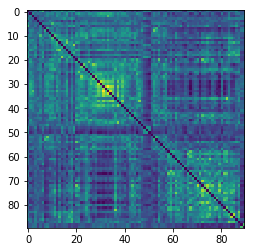

In [58]:
plt.imshow(x['cue'][dmn_fpn_mem][:,dmn_fpn_mem].mean(axis=2))

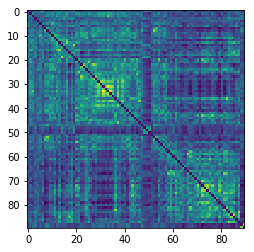

In [59]:
plt.imshow(x['cue_ya'][dmn_fpn_mem][:,dmn_fpn_mem].mean(axis=2))

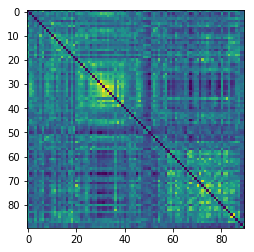

In [60]:
plt.imshow(x['cue_oa'][dmn_fpn_mem][:,dmn_fpn_mem].mean(axis=2))

In [64]:
pd.DataFrame(np.hstack((coords[dmn_fpn_mem], atlas.loc[dmn_fpn_mem].values))).values.tolist()

[[-41, -75, 26, 'Default mode'],
 [6, 67, -4, 'Default mode'],
 [8, 48, -15, 'Default mode'],
 [-13, -40, 1, 'Default mode'],
 [-18, 63, -9, 'Default mode'],
 [-46, -61, 21, 'Default mode'],
 [43, -72, 28, 'Default mode'],
 [-44, 12, -34, 'Default mode'],
 [46, 16, -30, 'Default mode'],
 [-68, -23, -16, 'Default mode'],
 [-44, -65, 35, 'Default mode'],
 [-39, -75, 44, 'Default mode'],
 [-7, -55, 27, 'Default mode'],
 [6, -59, 35, 'Default mode'],
 [-11, -56, 16, 'Default mode'],
 [-3, -49, 13, 'Default mode'],
 [8, -48, 31, 'Default mode'],
 [15, -63, 26, 'Default mode'],
 [-2, -37, 44, 'Default mode'],
 [11, -54, 17, 'Default mode'],
 [52, -59, 36, 'Default mode'],
 [23, 33, 48, 'Default mode'],
 [-10, 39, 52, 'Default mode'],
 [-16, 29, 53, 'Default mode'],
 [-35, 20, 51, 'Default mode'],
 [22, 39, 39, 'Default mode'],
 [13, 55, 38, 'Default mode'],
 [-10, 55, 39, 'Default mode'],
 [-20, 45, 39, 'Default mode'],
 [6, 54, 16, 'Default mode'],
 [6, 64, 22, 'Default mode'],
 [-7, 51, -1

## Age group differences in DMN-FPN FC during cue <a id='age-group-dif-mean-fc'></a>

In [145]:
x0 = np.load('/Volumes/psybrain/ADM/derivatives/nibs/memmatch_fc.npy', allow_pickle=True).flat[0]

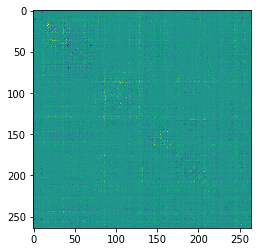

In [151]:
plt.imshow(x0['cue'][:,:,0] - x['cue'][:264,:264,0])

In [68]:
x = np.load('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/memmatch_fc_withhc.npy', allow_pickle=True).flat[0]
fc_subs = np.loadtxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/fcsubs.txt')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


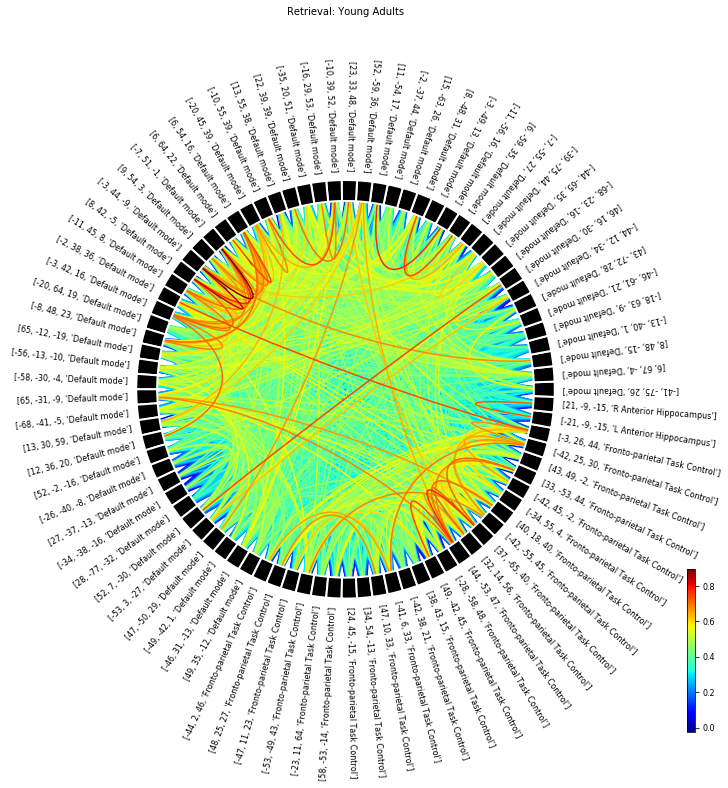

In [70]:
xpy = x['cue_ya'].mean(axis=2)

n_lines = int(np.sum((xpy > 0) / 2))
fig = plt.figure(figsize=(15, 15))
node_labels = pd.DataFrame(np.hstack((coords[dmn_fpn], atlas.loc[dmn_fpn].values))).values.tolist()             
plot_connectivity_circle(xpy[dmn_fpn][:,dmn_fpn], node_labels, n_lines=n_lines, fig=fig, title='Retrieval: Young Adults', 
                         fontsize_title=10, facecolor='white', textcolor='black', 
                         colormap='jet', colorbar=1, node_colors=['black'], 
                         node_edgecolor=['white'], show=False, interactive=False)
fig.savefig(results_dir + 'cue_ya_mean_dmn-fpn_fc.png')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


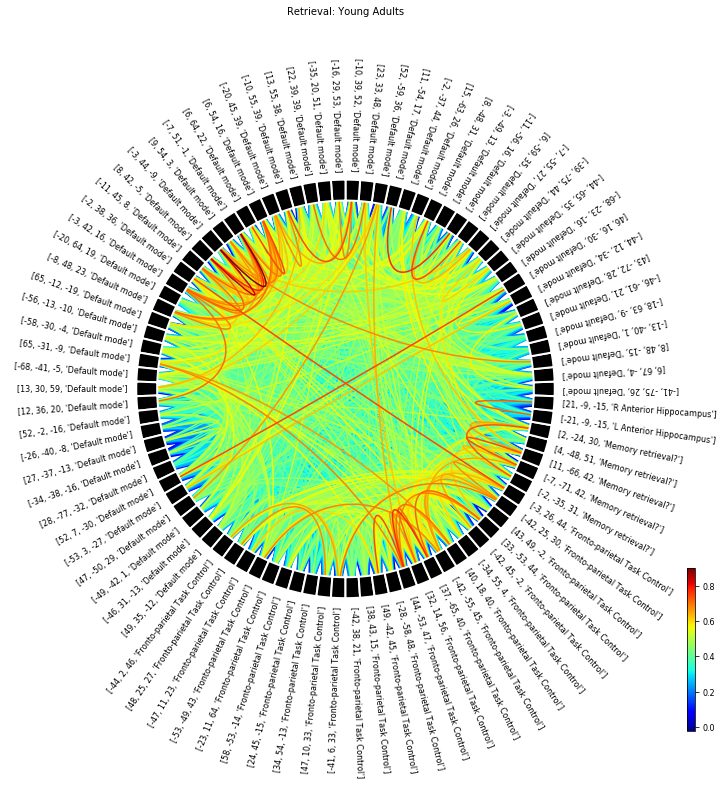

In [71]:
xpy = x['cue_ya'].mean(axis=2)

n_lines = int(np.sum((xpy > 0) / 2))
fig = plt.figure(figsize=(15, 15))
node_labels = pd.DataFrame(np.hstack((coords[dmn_fpn_mem], atlas.loc[dmn_fpn_mem].values))).values.tolist()             
plot_connectivity_circle(xpy[dmn_fpn_mem][:,dmn_fpn_mem], node_labels, n_lines=n_lines, fig=fig, title='Retrieval: Young Adults', 
                         fontsize_title=10, facecolor='white', textcolor='black', 
                         colormap='jet', colorbar=1, node_colors=['black'], 
                         node_edgecolor=['white'], show=False, interactive=False)
fig.savefig(results_dir + 'cue_ya_mean_dmn-fpn-mem_fc.png')

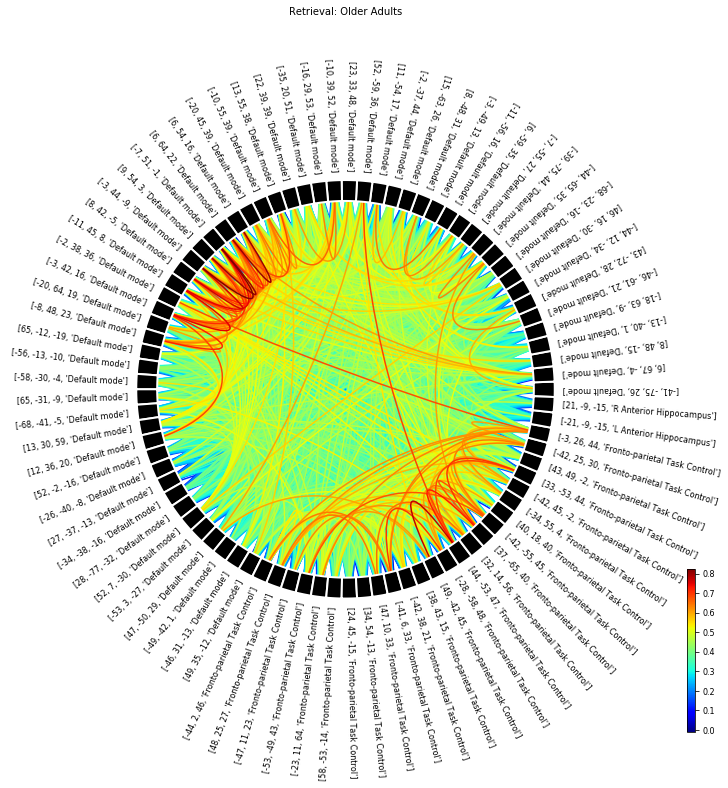

In [72]:
xpo = x['cue_oa'].mean(axis=2)
fig = plt.figure(figsize=(15, 15))

node_labels = pd.DataFrame(np.hstack((coords[dmn_fpn], atlas.loc[dmn_fpn].values))).values.tolist()
plot_connectivity_circle(xpo[dmn_fpn][:,dmn_fpn], node_labels, n_lines=n_lines, fig=fig, title='Retrieval: Older Adults', 
                         fontsize_title=10, facecolor='white', textcolor='black', 
                         colormap='jet', colorbar=1, node_colors=['black'], 
                         node_edgecolor=['white'], show=False, interactive=False)

fig.savefig(results_dir + 'cue_oa_mean_dmn-fpn_fc.png')


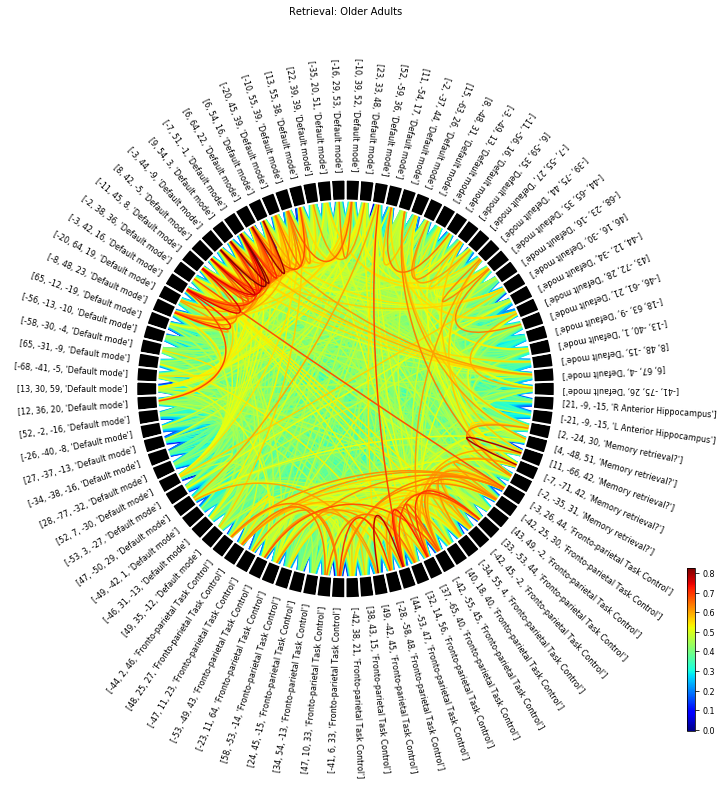

In [73]:
xpo = x['cue_oa'].mean(axis=2)
fig = plt.figure(figsize=(15, 15))

node_labels = pd.DataFrame(np.hstack((coords[dmn_fpn_mem], atlas.loc[dmn_fpn_mem].values))).values.tolist()
plot_connectivity_circle(xpo[dmn_fpn_mem][:,dmn_fpn_mem], node_labels, n_lines=n_lines, fig=fig, title='Retrieval: Older Adults', 
                         fontsize_title=10, facecolor='white', textcolor='black', 
                         colormap='jet', colorbar=1, node_colors=['black'], 
                         node_edgecolor=['white'], show=False, interactive=False)

fig.savefig(results_dir + 'cue_oa_mean_dmn-fpn-mem_fc.png')



In [74]:
x['cue_ya'].shape

(266, 266, 51)

In [75]:
x['cue_oa'].shape

(266, 266, 38)

In [43]:
x['cue_oa'][:,:,35]

array([[0.        , 0.63977629, 0.01653341, ..., 0.34015785, 0.03554068,
        0.21508494],
       [0.63977629, 0.        , 0.30250593, ..., 0.67654755, 0.31423401,
        0.39361927],
       [0.01653341, 0.30250593, 0.        , ..., 0.35144185, 0.09509778,
        0.32740648],
       ...,
       [0.34015785, 0.67654755, 0.35144185, ..., 0.        , 0.53777688,
        0.36343411],
       [0.03554068, 0.31423401, 0.09509778, ..., 0.53777688, 0.        ,
        0.19420943],
       [0.21508494, 0.39361927, 0.32740648, ..., 0.36343411, 0.19420943,
        0.        ]])

In [44]:
x['cue_ya'][fpn][:,fpn,:].shape

(25, 25, 51)